## 1. 라이브러리 임폴트

In [10]:
from __future__ import division
import time
import pickle
import gzip
from random import randint
from scipy import misc
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
# Loss Surface Visualization
from mpl_toolkits.mplot3d import Axes3D
import collections
%matplotlib inline 

## 2. 데이터 불러오기
###  2-1. 학습 데이터

#### TRAINING  (list) 
<ul>
    <li>TRAINING[0] : (60000, 784) ndarray of data</li>
    <li>TRAINING[1] : (60000, ) vector of label</li>
</ul>


###  2-2. 테스트 데이터

#### TESTING  (list) 
<ul>
    <li>TESTING[0] : (10000, 784) ndarray of data</li>
    <li>TESTING[1] : (10000, ) vector of label</li>
</ul>

In [11]:
START_TIME = time.time()
ft = gzip.open('/data_training', 'rb')
TRAINING = pickle.load(ft)
ft.close()

ft = gzip.open('/data_testing', 'rb')
TESTING = pickle.load(ft)
ft.close()

print('Import duration '+str(round((time.time() - START_TIME), 2))+'s')
print('----')

Import duration 3.04s
----


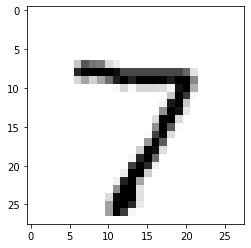

In [12]:
_ = plt.imshow(TESTING[0][0].reshape((28,28)), cmap=plt.cm.Greys)

0.0 ~ 0.1: 679
0.1 ~ 0.2: 6
0.2 ~ 0.3: 18
0.3 ~ 0.4: 3
0.4 ~ 0.5: 7
0.5 ~ 0.6: 5
0.6 ~ 0.7: 4
0.7 ~ 0.8: 11
0.8 ~ 0.9: 11
0.9 ~ 1.0: 40


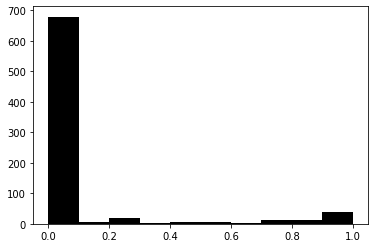

In [13]:
n_bins = 10
_ = plt.hist(TESTING[0][0], bins=n_bins, color="black")
for i in range(len(_[0])):
    print("%.1f ~ %.1f: %d"%(i/10, i/10 +0.1, _[0][i]))


In [14]:
# 신경망 코드 출처 : https://github.com/louisjc/mnist-neural-network

## 3. 신경망 생성

#### __init__ : 학습 파라미터를 초기화 함. 

<ul>
    <li>input_size: 입력 데이터 크기 (ex. 784)</li>
    <li>output_size: 출력 데이터 크기 (ex. 10)</li>
    <li>num_hidden: 은닉 노드의 수 (ex. 300)</li>
    <li>best: 가장 낮은 accuracy 를 기준으로 best accuracy 를 업데이트 함. (목표 정확도: .97)</li>
    <li>same: accuracy 가 높아지지 않는 횟수를 카운트 하여, 특정 이상이 되면 학습을 중단함. (10)</li>
    <li>layers(list) : 은닉층의 학습 파라미터 행렬의 집합으로써, 작은 값의 가중치로 초기화됨. 
        <ul>
            <li>h1 : (300,785) matrix of random weights</li>
            <li>h2 : (10,301) matrix of random weights</li>
        </ul>
    </li>
    <li>iteration: 이터레이션 카운트</li>
</ul> 

#### train  : 학습하는 메인 코드
#### feed_forward : 순전파
<ul>
    <li>hidden_outputs: (300,) vector after inner product of (300, 785) and (785, 1)</li>
    <li>outputs: (10,) vector after inner product of (10, 301) and (301, 1)</li>
</ul>

#### backpropagate : 역전파 
#### predict : 순전파 진행함.

#### predict_one : 하나의 인풋에 대한 예측한 라벨을 리턴함.
#### sauv : 최적화된 파라미터를 저장함.
#### load : 기존 학습된 파라미터를 로드함.
#### accu : 정확도를 계산함.
<ul>
<li>가장 낮은 성능을 보인 성과를 퍼센트로 반환</li>
<li>배치의 평균적인 성능을 퍼센트로 반환</li>
<li>가장 낮은 성능을 보인 인덱스를 반환</li>
</ul>

In [15]:
class Network:

    def __init__(self, num_hidden):
        self.input_size = 784
        self.output_size = 10
        self.num_hidden = num_hidden
        self.best = 0.
        self.same = 0

        # Standardize random weights
        np.random.seed(0)
        hidden_layer = np.random.rand(self.num_hidden, self.input_size + 1) / self.num_hidden
        output_layer = np.random.rand(self.output_size, self.num_hidden + 1) / self.output_size
        self.layers = [hidden_layer, output_layer]
        self.iteration = 0.

        print('Initialization with random weight')
        print('-----')

    def train(self, batchsize, training):
        start_time = time.time()
        print('Network training with '+str(batchsize)+' examples')
        print('Until convergence (10 iterations without improvements)')
        print('-----')
        
        inputs = training[0][0:batchsize]
        targets = np.zeros((batchsize, 10))
        for i in range(batchsize):
            targets[i, training[1][i]] = 1

        while self.same < 10:
            for input_vector, target_vector in zip(inputs, targets):
                self.backpropagate(input_vector, target_vector)
            
            # Messages and backups
            self.iteration += 1.
            accu = self.accu(TESTING)
            message = 'Iteration '+str(int(self.iteration)).zfill(2) + \
                ' (' + str(round(time.time()-start_time)).zfill(2)+'s) '
            message += 'Precision G:'+str(accu[1]).zfill(4)+'% Min:'+ \
                str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
            if accu[0] > self.best:
                self.same = 0
                self.best = accu[0]
                message += ' R'
                if accu[0] > 77:
                    self.sauv(file_name='ntMIN_'+str(accu))
                    message += 'S'
            else:
                self.same += 1
            print(message)
        # Final message
        print('10 Iterations without improvements.')
        print('Total duration: ' + str(round((time.time() - start_time), 2))+'s')

    def feed_forward(self, input_vector):
        """Takes a network (Matrix list) and returns the outputs of both
         layers by propagating the entry"""
        outputs = []
        for layer in self.layers:
            input_with_bias = np.append(input_vector, 1)   # initialize bias to 1
            output = np.inner(layer, input_with_bias)
            output = special.expit(output) # logistic sigmoid
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target):
        """Reduce error for one input vector:
        Calculating the partial derivatives for each coeff then subtracts"""
        c = 1./(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector)

        output_deltas = outputs * (1 - outputs) * (outputs - target) # (10, ) vector

        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * \
            np.dot(np.delete(self.layers[-1], 300, 1).T, output_deltas) # (10, ) vector
        
        self.layers[-1] -= c*np.outer(output_deltas, np.append(hidden_outputs, 1)) # (10, 301) 
        self.layers[0] -= c*np.outer(hidden_deltas, np.append(input_vector, 1)) # (300, 785)

    def predict(self, input_vector):
        return self.feed_forward(input_vector)[-1]

    def predict_one(self, input_vector):
        return np.argmax(self.feed_forward(input_vector)[-1]) # 가장 큰 원소의 index 를 반환함.

    def sauv(self, file_name=''):
        if file_name == '':
            file_name = 'nt_'+str(self.accu(TESTING)[0])
        sauvfile = self.layers
        f = open(file_name, 'wb')
        pickle.dump(sauvfile, f)
        f.close()

    def load(self, file_name):
        f = open(file_name, 'rb')
        self.layers = pickle.load(f, encoding='latin1')
        f.close()

    def accu(self, testing):
        """The lowest precision digit and total"""
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k]) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)



## 4. 신경망 훈련 

In [16]:
nt1=Network(300) # hidden_size
nt1.train(600,TRAINING) # batch_size



Initialization with random weight
-----
Network training with 600 examples
Until convergence (10 iterations without improvements)
-----
Iteration 01 (05s) Precision G:9.58% Min:00.0% (0)
Iteration 02 (09s) Precision G:14.77% Min:00.0% (2)
Iteration 03 (13s) Precision G:34.29% Min:00.0% (2)
Iteration 04 (17s) Precision G:45.47% Min:00.0% (4)
Iteration 05 (21s) Precision G:61.14% Min:00.0% (5)
Iteration 06 (26s) Precision G:68.14% Min:00.0% (5)
Iteration 07 (30s) Precision G:72.33% Min:1.35% (5) R
Iteration 08 (34s) Precision G:74.95% Min:5.38% (5) R
Iteration 09 (38s) Precision G:76.76% Min:13.45% (5) R
Iteration 10 (42s) Precision G:78.4% Min:24.1% (5) R
Iteration 11 (46s) Precision G:79.79% Min:36.21% (5) R
Iteration 12 (50s) Precision G:81.01% Min:46.19% (5) R
Iteration 13 (54s) Precision G:81.79% Min:52.24% (5) R
Iteration 14 (58s) Precision G:82.33% Min:56.17% (5) R
Iteration 15 (62s) Precision G:82.97% Min:60.2% (5) R
Iteration 16 (65s) Precision G:83.33% Min:61.66% (5) R
Iteratio

In [17]:
WEIGHTS = pickle.load( open( 'ntMIN_[77.11 85.69  9.  ]', "rb" ) ) # (300,785) , (10,301)

## 5. Loss Surface

In [18]:
def test_nn(WEIGHTS, network, alpha, beta):
    """Test Network"""
    
    np.random.seed(0)
    w0 = WEIGHTS[0].flatten()
    w1 = WEIGHTS[1].flatten()
    nh = w0 + alpha * np.random.rand(len(w0)) + beta * np.random.rand(len(w0))
    no = w1 + alpha * np.random.rand(len(w1)) + beta * np.random.rand(len(w1))
    
    hidden_layer = nh.reshape(WEIGHTS[0].shape)
    output_layer = no.reshape(WEIGHTS[1].shape)
    network.layers = [hidden_layer, output_layer]
        
    ok, nb = 0, 10000
    for k in range(nb):
        if network.predict_one(TESTING[0][k]) == TESTING[1][k]:
            ok += 1
    return 100 - round((ok*100./nb), 1)



NameError: ignored

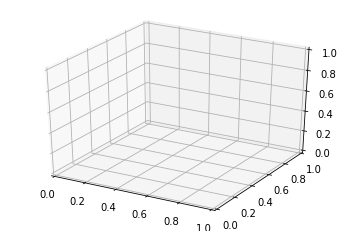

In [19]:
ms = np.linspace(-1.0, 1.0, 10)
bs = np.linspace(-1.0, 1.0, 10)

M, B = np.meshgrid(ms, bs)

zs = np.array([test_nn(WEIGHTS, nt1, alpha, beta) 
               for alpha, beta in zip(np.ravel(M), np.ravel(B))])

Z = zs.reshape(M.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(M, B, Z, rstride=1, cstride=1, cmap=cm.coolwarm, alpha=0.5)

# ax.set_xlabel('m')
# ax.set_ylabel('b')
# ax.set_zlabel('error')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.contour(M, B, Z)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

# X, Y, Z = axes3d.get_test_data(0.05)

plt.subplot(131)
cset = plt.contourf(M, B, Z, cmap=cm.coolwarm)
plt.subplot(132)
cset = plt.contourf(B, Z, M, cmap=cm.coolwarm)
plt.subplot(133)
cset = plt.contourf(M, Z, B, cmap=cm.coolwarm)

plt.show()